
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [6]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [7]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [8]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'run on destop2.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on run on destop2.csv size is (96397, 1132)
100
200
300
400
500
600
700
800
900
1000
1100
run on destop2.csv                                variable     score
9                                 Fraud  1.000000
639         Cardnum_fulladdress_total_7  0.685104
931           Cardnum_Merch zip_total_7  0.684517
712            Cardnum_Merchnum_total_7  0.681329
630         Cardnum_fulladdress_total_3  0.677825
922           Cardnum_Merch zip_total_3  0.677563
721           Cardnum_Merchnum_total_14  0.675541
703            Cardnum_Merchnum_total_3  0.675292
849         Cardnum_Merch state_total_3  0.674241
648        Cardnum_fulladdress_total_14  0.672789
940          Cardnum_Merch zip_total_14  0.671828
785   Cardnum_Merch description_total_7  0.671267
858         Cardnum_Merch state_total_7  0.669699
867        Cardnum_Merch state_total_14  0.669055
794  Cardnum_Merch description_total_14  0.665538
776   Cardnum_Merch description_total_3  0.661331
621         Cardnum_fu

In [9]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [10]:
filter_score.head(30)

,variable,score
9,Fraud,1.000000
639,Cardnum_fulladdress_total_7,0.685104
931,Cardnum_Merch zip_total_7,0.684517
712,Cardnum_Merchnum_total_7,0.681329
630,Cardnum_fulladdress_total_3,0.677825
922,Cardnum_Merch zip_total_3,0.677563
721,Cardnum_Merchnum_total_14,0.675541
703,Cardnum_Merchnum_total_3,0.675292
849,Cardnum_Merch state_total_3,0.674241
648,Cardnum_fulladdress_total_14,0.672789


In [11]:
filter_score.tail(10)

,variable,score
1016,Merch state_count_0_by_90,0.052223
1015,Merch state_count_0_by_60,0.045222
1088,Cardnum_Merchnum_count_0_by_90,0.044780
1014,Merch state_count_0_by_30,0.044766
1012,Merch state_count_0_by_7,0.040726
1017,Merch state_count_1_by_3,0.036497
1022,Merch state_count_1_by_90,0.028560
1131,RANDOM,0.027262
242,Merch state_day_since,0.008086
7,Transtype,0.000000


In [12]:
filter_score.shape

(1132, 2)

In [13]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_fulladdress_total_7', 'Cardnum_Merch zip_total_7', 'Cardnum_Merchnum_total_7', 'Cardnum_fulladdress_total_3', 'Cardnum_Merch zip_total_3', 'Cardnum_Merchnum_total_14', 'Cardnum_Merchnum_total_3', 'Cardnum_Merch state_total_3', 'Cardnum_fulladdress_total_14', 'Cardnum_Merch zip_total_14', 'Cardnum_Merch description_total_7', 'Cardnum_Merch state_total_7', 'Cardnum_Merch state_total_14', 'Cardnum_Merch description_total_14', 'Cardnum_Merch description_total_3', 'Cardnum_fulladdress_total_1', 'Cardnum_Merch zip_total_1', 'Cardnum_Merchnum_total_30', 'Cardnum_Merch description_max_14', 'Cardnum_Merch state_total_1', 'Cardnum_Merchnum_total_1', 'Cardnum_fulladdress_max_14', 'Cardnum_fulladdress_max_7', 'Cardnum_Merch zip_max_14', 'Cardnum_Merch zip_max_7', 'Cardnum_fulladdress_total_30', 'Cardnum_Merch description_total_30', 'Cardnum_Merch description_max_7', 'Cardnum_Merch zip_total_30', 'Cardnum_Merchnum_max_14', 'Cardnum_Merch description_max_30', 'Cardnum_fulladd

In [14]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_fulladdress_total_7,Cardnum_Merch zip_total_7,Cardnum_Merchnum_total_7,Cardnum_fulladdress_total_3,Cardnum_Merch zip_total_3,Cardnum_Merchnum_total_14,Cardnum_Merchnum_total_3,Cardnum_Merch state_total_3,Cardnum_fulladdress_total_14,Cardnum_Merch zip_total_14,...,Cardnum_Merch state_total_0,Cardnum_fulladdress_total_0,Cardnum_Merch description_total_0,Merchnum_Merch description_total_1,Cardnum_Merch zip_total_0,Merch state_actual/avg_90,Merchnum_Merch description_max_0,Merch description_max_0,Merch state_actual/avg_60,fulladdress_total_3
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,1023.04,174.20,174.20,1023.04,174.20,174.20,1023.04,1023.04,...,174.20,174.20,174.20,174.20,174.20,0.586571,174.20,174.20,0.586571,3171.85
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.00,250.00,250.00,250.00,250.00,0.702977,250.00,250.00,0.702977,288.90
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,...,53.88,53.88,53.88,1116.55,53.88,0.153205,53.88,53.88,0.153205,3116.86
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,1269.00,1269.00,1269.00,1481.35,1269.00,2.775053,1269.00,1269.00,2.775053,6604.53
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,288.38,288.38,288.38,1189.68,288.38,0.820872,288.38,288.38,0.820872,3538.98


In [15]:
df_keep.shape

(80983, 80)

In [16]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [17]:
Y = Y.values
Y_save = Y.copy()

In [18]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [19]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:38.436730


In [20]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [21]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [22]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [23]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [24]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   47.3s finished

[2022-04-12 00:05:21] Features: 1/20 -- score: 0.6198209035017375[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   21.4s finished

[2022-04-12 00:05:43] Features: 2/20 -- score: 0.6692729216786955[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   22.2s finished

[2022-04-12 00:06:05] Features: 3/20 -- score: 0.6681368618016572[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  77 out o

Wall time: 11min 44s


SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x0000024E5CA9BD30>,
                          verbose=2)

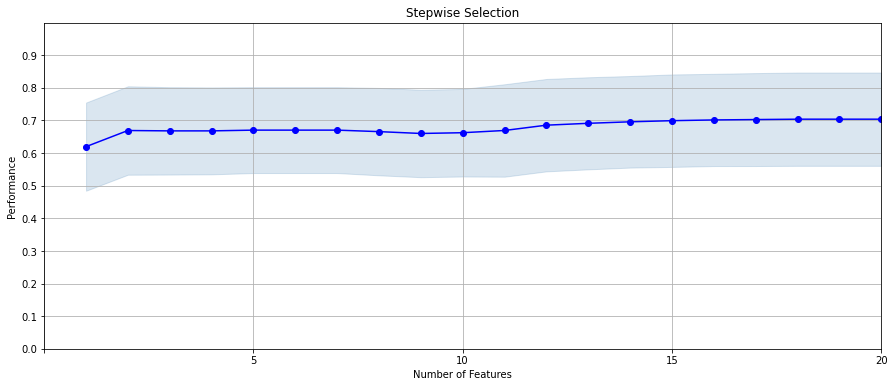

In [25]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [26]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [27]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [28]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(2,)","[0.5057471264367817, 0.5862068965517241, 0.747...",0.619821,"(Cardnum_Merchnum_total_7,)",0.10039,0.135166,0.045055,1.0,Cardnum_Merchnum_total_7
2,"(2, 64)","[0.8045977011494253, 0.6896551724137931, 0.793...",0.669273,"(Cardnum_Merchnum_total_7, Cardnum_Merch zip_m...",0.100687,0.135566,0.045189,2.0,Cardnum_Merch zip_max_90
3,"(2, 17, 64)","[0.8045977011494253, 0.7011494252873564, 0.781...",0.668137,"(Cardnum_Merchnum_total_7, Cardnum_Merchnum_to...",0.099483,0.133945,0.044648,3.0,Cardnum_Merchnum_total_30
4,"(2, 17, 28, 64)","[0.8045977011494253, 0.6896551724137931, 0.793...",0.668137,"(Cardnum_Merchnum_total_7, Cardnum_Merchnum_to...",0.098943,0.133218,0.044406,4.0,Cardnum_Merch zip_total_30
5,"(2, 17, 28, 44, 64)","[0.8045977011494253, 0.6896551724137931, 0.793...",0.670436,"(Cardnum_Merchnum_total_7, Cardnum_Merchnum_to...",0.097723,0.131576,0.043859,5.0,Cardnum_Merchnum_total_60
6,"(2, 17, 28, 39, 44, 64)","[0.8045977011494253, 0.6896551724137931, 0.793...",0.670436,"(Cardnum_Merchnum_total_7, Cardnum_Merchnum_to...",0.097723,0.131576,0.043859,6.0,Cardnum_fulladdress_total_60
7,"(2, 17, 28, 39, 41, 44, 64)","[0.8045977011494253, 0.6896551724137931, 0.793...",0.670436,"(Cardnum_Merchnum_total_7, Cardnum_Merchnum_to...",0.097723,0.131576,0.043859,7.0,Cardnum_Merch zip_total_60
8,"(2, 17, 28, 39, 41, 42, 44, 64)","[0.8045977011494253, 0.6896551724137931, 0.793...",0.665851,"(Cardnum_Merchnum_total_7, Cardnum_Merchnum_to...",0.099495,0.133961,0.044654,8.0,Cardnum_Merch description_total_60
9,"(2, 14, 17, 28, 39, 41, 42, 44, 64)","[0.632183908045977, 0.6091954022988506, 0.7356...",0.660198,"(Cardnum_Merchnum_total_7, Cardnum_Merch descr...",0.099532,0.134011,0.04467,9.0,Cardnum_Merch description_total_3
10,"(2, 14, 17, 28, 31, 39, 41, 42, 44, 64)","[0.632183908045977, 0.6091954022988506, 0.7816...",0.66251,"(Cardnum_Merchnum_total_7, Cardnum_Merch descr...",0.09971,0.134251,0.04475,10.0,Cardnum_fulladdress_max_30


In [29]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [30]:
ordered_vars_FS['variable name']

1               Cardnum_Merchnum_total_7
2               Cardnum_Merch zip_max_90
3              Cardnum_Merchnum_total_30
4             Cardnum_Merch zip_total_30
5              Cardnum_Merchnum_total_60
6           Cardnum_fulladdress_total_60
7             Cardnum_Merch zip_total_60
8     Cardnum_Merch description_total_60
9      Cardnum_Merch description_total_3
10            Cardnum_fulladdress_max_30
11             Merch state_actual/med_90
12            Cardnum_Merch state_max_14
13               Merch description_max_0
14      Cardnum_Merch description_max_90
15    Cardnum_Merch description_total_90
16               Cardnum_Merchnum_max_90
17             Cardnum_fulladdress_max_7
18       Cardnum_Merch description_max_7
19              Cardnum_Merch zip_max_14
20               Cardnum_Merch zip_max_7
Name: variable name, dtype: object

In [31]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [32]:
vars_keep

1               Cardnum_Merchnum_total_7
2               Cardnum_Merch zip_max_90
3              Cardnum_Merchnum_total_30
4             Cardnum_Merch zip_total_30
5              Cardnum_Merchnum_total_60
6           Cardnum_fulladdress_total_60
7             Cardnum_Merch zip_total_60
8     Cardnum_Merch description_total_60
9      Cardnum_Merch description_total_3
10            Cardnum_fulladdress_max_30
11             Merch state_actual/med_90
12            Cardnum_Merch state_max_14
13               Merch description_max_0
14      Cardnum_Merch description_max_90
15    Cardnum_Merch description_total_90
16               Cardnum_Merchnum_max_90
17             Cardnum_fulladdress_max_7
18       Cardnum_Merch description_max_7
19              Cardnum_Merch zip_max_14
20               Cardnum_Merch zip_max_7
Name: variable name, dtype: object

In [33]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_Merchnum_total_7',
 'Cardnum_Merch zip_max_90',
 'Cardnum_Merchnum_total_30',
 'Cardnum_Merch zip_total_30',
 'Cardnum_Merchnum_total_60',
 'Cardnum_fulladdress_total_60',
 'Cardnum_Merch zip_total_60',
 'Cardnum_Merch description_total_60',
 'Cardnum_Merch description_total_3',
 'Cardnum_fulladdress_max_30',
 'Merch state_actual/med_90',
 'Cardnum_Merch state_max_14',
 'Merch description_max_0',
 'Cardnum_Merch description_max_90',
 'Cardnum_Merch description_total_90',
 'Cardnum_Merchnum_max_90',
 'Cardnum_fulladdress_max_7',
 'Cardnum_Merch description_max_7',
 'Cardnum_Merch zip_max_14',
 'Cardnum_Merch zip_max_7',
 'Recnum',
 'Fraud']

In [34]:
df = pd.read_csv(file_name)

In [35]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [36]:
df_keep.to_csv('vars_final.csv',index=False)

In [37]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:12:41.631618
